# Resource Allocation for Demand Variability

In [59]:
#pip install cvxpy
#pip install holidays
#pip install meteostat

In [60]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import datetime as dt
import seaborn as sns
import holidays
from meteostat import Point, Daily
import matplotlib.pyplot as plt
import cvxpy as cp
import calendar
from scipy.interpolate import interp1d

## Attendance Data

### By month & day of the week
Data obtained from `attendance.csv`

In [61]:
# Preparing attendance.csv for use
attendance_data = pd.read_csv(r"C:\Users\joann\Downloads\attendance.csv")
attendance_data.isnull().any()
attendance_data.drop_duplicates(inplace = True)
attendance_data["USAGE_DATE"] = pd.to_datetime(attendance_data["USAGE_DATE"])
attendance_data["Year"] = attendance_data["USAGE_DATE"].dt.year
attendance_data["Month"] = attendance_data["USAGE_DATE"].dt.month
attendance_data["Day_of_Week"] = attendance_data["USAGE_DATE"].dt.day_name()
for x in attendance_data.index:
  if attendance_data.loc[x, "attendance"] < 0:
    attendance_data.loc[x, "attendance"] = 0

attendance_data["mean_attendance"] = attendance_data.groupby(["Year", "FACILITY_NAME"])["attendance"].transform("mean")
attendance_data["std_attendance"] = attendance_data.groupby(["Year", "FACILITY_NAME"])["attendance"].transform("std")

# Standardize attendance
attendance_data["standardized_attendance"] = (attendance_data["attendance"] - attendance_data["mean_attendance"]) / attendance_data["std_attendance"]

attendance_data.head()

,USAGE_DATE,FACILITY_NAME,attendance,Year,Month,Day_of_Week,mean_attendance,std_attendance,standardized_attendance
0,2018-06-01,PortAventura World,46804,2018,6,Friday,45461.004673,13418.682302,0.100084
1,2018-06-01,Tivoli Gardens,20420,2018,6,Friday,22760.574766,7124.590921,-0.328521
2,2018-06-02,PortAventura World,57940,2018,6,Saturday,45461.004673,13418.682302,0.929972
3,2018-06-02,Tivoli Gardens,29110,2018,6,Saturday,22760.574766,7124.590921,0.891199
4,2018-06-03,PortAventura World,44365,2018,6,Sunday,45461.004673,13418.682302,-0.081678


In [62]:
# Group by Month and Day_of_Week, then calculate mean attendance for each combination
mean_month_day_attendance = attendance_data.groupby(["Month", "Day_of_Week"])["attendance"].mean().reset_index()
mean_month_day_attendance.rename(columns={"attendance": "mean_month_day_attendance"}, inplace=True)

# Compute the overall mean attendance (average of all month and day combinations)
overall_mean = mean_month_day_attendance["mean_month_day_attendance"].mean()

print(f"Overall Mean Daily Attendance: {overall_mean}")

# Add a new column for the absolute difference from the overall mean
mean_month_day_attendance["abs_diff_from_overall_mean"] = (
    mean_month_day_attendance["mean_month_day_attendance"] - overall_mean
)

# Add a new column for the percentage difference from the overall mean
mean_month_day_attendance["pct_diff_from_overall_mean"] = (mean_month_day_attendance["abs_diff_from_overall_mean"] / overall_mean)

# Adjustor
mean_month_day_attendance["adjuster_month_day"] = (1 + mean_month_day_attendance["pct_diff_from_overall_mean"])

adjust_month_day = mean_month_day_attendance[["Month", "Day_of_Week", "adjuster_month_day"]]
adjust_month_day

Overall Mean Daily Attendance: 26840.7913886349


,Month,Day_of_Week,adjuster_month_day
0,1,Friday,0.701788
1,1,Monday,0.573666
2,1,Saturday,1.324958
3,1,Sunday,1.024063
4,1,Thursday,0.633080
...,...,...,...
79,12,Saturday,1.454402
80,12,Sunday,1.331022
81,12,Thursday,0.959565
82,12,Tuesday,1.173001


### By the hour

#### Rides
Guests carried on all rides for every hour will optimize overall ride staffing. Data obtained from `waiting_times.csv`. 

In [63]:
## Adjust by hour of day

# Rides Demand by day of week & hour
waiting_times = pd.read_csv(r"C:\Users\joann\Downloads\waiting_times.csv")
waiting_times['DEB_TIME'] = pd.to_datetime(waiting_times['DEB_TIME'])
waiting_times['DEB_TIME_DAY'] = waiting_times['DEB_TIME'].dt.dayofweek
waiting_times = waiting_times[waiting_times['GUEST_CARRIED'] >= 0]
rides_hourly_demand = waiting_times[['DEB_TIME', 'DEB_TIME_DAY', 'DEB_TIME_HOUR', 'ENTITY_DESCRIPTION_SHORT', 'GUEST_CARRIED']]

# Group by hour and compute the mean guests carried across all rides
rides_hourly_agg = rides_hourly_demand.groupby("DEB_TIME_HOUR")["GUEST_CARRIED"].mean().reset_index()

# Rename column for clarity
rides_hourly_agg.rename(columns={"GUEST_CARRIED": "mean_guest_carried"}, inplace=True)

# Compute the overall mean of guest carried across all hours
overall_mean_guest_carried = rides_hourly_agg["mean_guest_carried"].mean()

print(f"Overall mean guest carried across all hours: {overall_mean_guest_carried}")

# Add a new column to show the difference between each hour's mean and the overall mean
rides_hourly_agg["abs_diff_from_overall_mean"] = rides_hourly_agg["mean_guest_carried"] - overall_mean_guest_carried

# Add a new column to show the difference between each hour's mean and the overall mean
rides_hourly_agg["pct_diff_from_overall_mean"] = (rides_hourly_agg["abs_diff_from_overall_mean"] / overall_mean_guest_carried)

# Adjuster
rides_hourly_agg["adjuster_hourly_rides"] = (1 + rides_hourly_agg["pct_diff_from_overall_mean"])

adjust_hour_rides = rides_hourly_agg[["DEB_TIME_HOUR", "adjuster_hourly_rides"]]
adjust_hour_rides

Overall mean guest carried across all hours: 75.26821131211832


,DEB_TIME_HOUR,adjuster_hourly_rides
0,9,0.691087
1,10,1.259112
2,11,1.384399
3,12,1.368495
4,13,1.369611
5,14,1.369344
6,15,1.363377
7,16,1.317302
8,17,1.168627
9,18,1.004164


#### Eateries
Crowd levels in eateries for every hour will be used to optimize overall eatery staffing. Data obtained from `air_reserve` and `hpg_reserve`.

In [64]:
hpg_reserve = pd.read_csv(r"C:\Users\joann\Downloads\hpg_reserve.csv")
hpg_reserve.drop(columns=["reserve_datetime"], inplace=True)

# Ensure datetime format
hpg_reserve["visit_datetime"] = pd.to_datetime(hpg_reserve["visit_datetime"])

# Extract hour before dropping visit_datetime
hpg_reserve["hour"] = hpg_reserve["visit_datetime"].dt.hour

# Group by store_id and hour, then compute the sum of reserve_visitors
hpg_hourly_sum = hpg_reserve.groupby(["hpg_store_id", "hour"])["reserve_visitors"].sum().reset_index()

# Rename for clarity
hpg_hourly_sum.rename(columns={"reserve_visitors": "sum_reserve_visitors"}, inplace=True)

# Compute the mean of reserve visitors per hour across all restaurants
hpg_hourly_all_sum = hpg_hourly_sum.groupby("hour")["sum_reserve_visitors"].mean().reset_index()

# Rename for clarity
hpg_hourly_all_sum.rename(columns={"sum_reserve_visitors": "hpg_mean_reserve_visitors_per_hour"}, inplace=True)

hpg_hourly_all_sum_relhrs = hpg_hourly_all_sum.loc[hpg_hourly_all_sum["hour"].between(9,22)]

In [65]:
air_reserve = pd.read_csv(r"C:\Users\joann\Downloads\air_reserve.csv")
air_reserve.drop(columns=["reserve_datetime"], inplace=True)

# Ensure datetime format
air_reserve["visit_datetime"] = pd.to_datetime(air_reserve["visit_datetime"])

# Extract hour before dropping visit_datetime
air_reserve["hour"] = air_reserve["visit_datetime"].dt.hour

# Group by store_id and hour, then compute the sum of reserve_visitors
air_hourly_sum = air_reserve.groupby(["air_store_id", "hour"])["reserve_visitors"].sum().reset_index()

# Rename for clarity
air_hourly_sum.rename(columns={"reserve_visitors": "sum_reserve_visitors"}, inplace=True)

# Compute the mean of reserve visitors per hour across all restaurants
air_hourly_all_sum = air_hourly_sum.groupby("hour")["sum_reserve_visitors"].mean().reset_index()

# Rename for clarity
air_hourly_all_sum.rename(columns={"sum_reserve_visitors": "air_mean_reserve_visitors_per_hour"}, inplace=True)

air_hourly_all_sum_relhrs = air_hourly_all_sum.loc[air_hourly_all_sum["hour"].between(9,22)]

In [66]:
eatery_merging = hpg_hourly_all_sum_relhrs.merge(
    air_hourly_all_sum_relhrs[['hour', 'air_mean_reserve_visitors_per_hour']],
    on='hour',
    how='left'
)

# Calculate percentage difference from the mean
eatery_merging['hpg_pct_diff'] = (eatery_merging['hpg_mean_reserve_visitors_per_hour'] - eatery_merging['hpg_mean_reserve_visitors_per_hour'].mean()) / eatery_merging['hpg_mean_reserve_visitors_per_hour'].mean()
eatery_merging['air_pct_diff'] = (eatery_merging['air_mean_reserve_visitors_per_hour'] - eatery_merging['air_mean_reserve_visitors_per_hour'].mean()) / eatery_merging['air_mean_reserve_visitors_per_hour'].mean()

eatery_ah_pct = eatery_merging[["hour", "hpg_pct_diff", "air_pct_diff"]]

# Compute combined percentage difference and adjuster
eatery_ah_pct['combined_pct_diff'] = eatery_ah_pct[['hpg_pct_diff', 'air_pct_diff']].mean(axis=1)
eatery_ah_pct['adjuster'] = 1 + eatery_ah_pct["combined_pct_diff"]

adjust_hour_eatery = eatery_ah_pct[["hour", "adjuster"]]
adjust_hour_eatery

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,hour,adjuster
0,9,0.100132
1,10,0.289413
2,11,0.845219
3,12,0.862737
4,13,0.476867
5,14,0.239730
6,15,0.201971
7,16,0.332835
8,17,1.158234
9,18,3.482398


#### Merchandise
Merchandise store footfall for every hour will be used to optimize overall merchandise store staffing. Data obtained from BestTime app data for Yodobashi Akiba. It is a large shopping centre in Tokyo, Japan, and follows similar opening hours to a theme park. https://besttime.app/app/Japan/Tokyo/?page=2& 

In [97]:
retail_raw = pd.read_csv(r"C:\Users\joann\Downloads\retail_daily_hourly.csv")
retail_daily_hourly = retail_raw[['day','hour','peak_frc']]
retail_daily_hourly

,day,hour,peak_frc
0,1,9,0.14
1,1,10,0.25
2,1,11,0.37
3,1,12,0.47
4,1,13,0.51
...,...,...,...
86,7,17,0.78
87,7,18,0.70
88,7,19,0.61
89,7,20,0.49


In [98]:
# Compute mean hourly peak frc
mean_hourly_peak_frc = retail_daily_hourly.groupby("hour")["peak_frc"].mean()

# Define smoothing factor (alpha)
alpha = 0.7  # More weight on recent hours

# Apply exponential smoothing to get estimated demand at 22:00
extrapolated_peak_frc = (
    alpha * mean_hourly_peak_frc[21] +
    (1 - alpha) * mean_hourly_peak_frc[20]
)

# Add the extrapolated value for 22:00 to mean_hourly_peak_frc
mean_hourly_peak_frc[22] = extrapolated_peak_frc

In [99]:
# Compute overall mean peak frc
overall_mean_peak_frc = retail_daily_hourly["peak_frc"].mean()

# Create DataFrame and calculate percentage difference
mean_hourly_peak_frc = mean_hourly_peak_frc.reset_index()
mean_hourly_peak_frc.rename(columns={"index": "hour"}, inplace=True)

# Percentage difference from overall mean
mean_hourly_peak_frc["pct_diff"] = mean_hourly_peak_frc["peak_frc"] - overall_mean_peak_frc

# Add Adjuster
mean_hourly_peak_frc["adjuster"] = 1 + mean_hourly_peak_frc["pct_diff"]

adjust_hour_merch = mean_hourly_peak_frc[['hour', 'adjuster']]
adjust_hour_merch

,hour,adjuster
0,9,0.589890
1,10,0.718462
2,11,0.848462
3,12,0.962747
4,13,1.025604
5,14,1.064176
6,15,1.085604
7,16,1.118462
8,17,1.171319
9,18,1.225604


#### General Service
General Service staff includes park maintenance and cleaning staff, security, crowd management and ticketing.

In [100]:
park_raw = pd.read_csv(r"C:\Users\joann\Downloads\park_daily_hourly_peaks.csv")
park_raw['hour_adjusted'] = park_raw['hour'] + 1
park_daily_hourly = park_raw[['day','hour_adjusted','peak_frc']]
park_daily_hourly

,day,hour_adjusted,peak_frc
0,1,9,0.59
1,1,10,0.77
2,1,11,0.88
3,1,12,0.94
4,1,13,0.96
...,...,...,...
93,7,18,0.88
94,7,19,0.85
95,7,20,0.81
96,7,21,0.75


In [101]:
park_daily_hourly["prev_peak_frc"] = park_daily_hourly.groupby("day")["peak_frc"].shift(fill_value=0)
park_daily_hourly["peak_frc_diff"] = park_daily_hourly["peak_frc"] - park_daily_hourly["prev_peak_frc"]
park_daily_hourly = park_daily_hourly.drop(columns=["prev_peak_frc"])
park_daily_hourly

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,day,hour_adjusted,peak_frc,peak_frc_diff
0,1,9,0.59,0.59
1,1,10,0.77,0.18
2,1,11,0.88,0.11
3,1,12,0.94,0.06
4,1,13,0.96,0.02
...,...,...,...,...
93,7,18,0.88,-0.03
94,7,19,0.85,-0.03
95,7,20,0.81,-0.04
96,7,21,0.75,-0.06


In [102]:
# Compute mean hourly peak frc
park_mean_hourly_peaks = park_daily_hourly.groupby("hour_adjusted")["peak_frc_diff"].mean()

# Compute overall mean peak frc
overall_park_mean_peaks = park_daily_hourly["peak_frc_diff"].mean()

# Create DataFrame and calculate percentage difference
park_mean_hourly_peaks = park_mean_hourly_peaks.reset_index()
park_mean_hourly_peaks.rename(columns={"index": "hour_adjusted"}, inplace=True)

# Percentage Difference from overall mean
park_mean_hourly_peaks["pct_diff"] = park_mean_hourly_peaks["peak_frc_diff"] - overall_park_mean_peaks

# Add Adjuster
park_mean_hourly_peaks["adjuster"] = 1 + park_mean_hourly_peaks["pct_diff"]

adjust_hour_general = park_mean_hourly_peaks[['hour_adjusted', 'adjuster']]
adjust_hour_general

,hour_adjusted,adjuster
0,9,1.528571
1,10,1.111429
2,11,1.051429
3,12,1.005714
4,13,0.980000
5,14,0.968571
6,15,0.954286
7,16,0.952857
8,17,0.938571
9,18,0.931429


### By public holiday
Data obtained from `attendance.csv`

In [73]:
#PortAventura World
portaventura_df = attendance_data[attendance_data["FACILITY_NAME"] == "PortAventura World"]

#Tivoli Gardens	
tivoli_df = attendance_data[attendance_data["FACILITY_NAME"] == "Tivoli Gardens"]

In [74]:
# SPAIN
spain_holidays = holidays.Spain(years=[2018, 2019, 2020, 2021, 2022])
portaventura_df["is_holiday"] = portaventura_df["USAGE_DATE"].apply(lambda x: x in spain_holidays)

#Check average attendance on holidays
overall_daily_attendance = portaventura_df["attendance"].mean()
holiday_attendance = portaventura_df[portaventura_df["is_holiday"] == True]["attendance"].mean()
non_holiday_attendance = portaventura_df[portaventura_df["is_holiday"] == False]["attendance"].mean()

print(f"Overall mean daily attendance for PortAventura: {overall_daily_attendance}")
print(f"Average attendance for PortAventura on holidays: {holiday_attendance}")
print(f"Average attendance for PortAventura on non-holidays: {non_holiday_attendance}")

ph_adjuster_spain = (holiday_attendance - overall_daily_attendance) / overall_daily_attendance
non_ph_adjuster_spain = (non_holiday_attendance - overall_daily_attendance) / overall_daily_attendance

print(f"Adjuster for Public Holidays in Spain: {ph_adjuster_spain}")
print(f"Adjuster for Non Public Holidays in Spain: {non_ph_adjuster_spain}")

Overall mean daily attendance for PortAventura: 34939.69373942471
Average attendance for PortAventura on holidays: 43767.57692307692
Average attendance for PortAventura on non-holidays: 34741.14273356401
Adjuster for Public Holidays in Spain: 0.2526605770928995
Adjuster for Non Public Holidays in Spain: -0.005682677339459851


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
# DENMARK
denmark_holidays = holidays.Denmark(years=[2018, 2019, 2020, 2021, 2022])
tivoli_df["is_holiday"] = tivoli_df["USAGE_DATE"].apply(lambda x: x in denmark_holidays)

#Check average attendance on holidays
overall_daily_attendance = tivoli_df["attendance"].mean()
holiday_attendance = tivoli_df[tivoli_df["is_holiday"] == True]["attendance"].mean()
non_holiday_attendance = tivoli_df[tivoli_df["is_holiday"] == False]["attendance"].mean()

print(f"Overall mean daily attendance for Tivoli: {overall_daily_attendance}")
print(f"Average attendance for Tivoli on holidays: {holiday_attendance}")
print(f"Average attendance for Tivoli on non-holidays: {non_holiday_attendance}")

ph_adjuster_denmark = (holiday_attendance - overall_daily_attendance) / overall_daily_attendance
non_ph_adjuster_denmark = (non_holiday_attendance - overall_daily_attendance) / overall_daily_attendance

print(f"Adjuster for Public Holidays in Denmark: {ph_adjuster_denmark}")
print(f"Adjuster for Non Public Holidays in Denmark: {non_ph_adjuster_denmark}")

Overall mean daily attendance for Tivoli: 17345.38227848101
Average attendance for Tivoli on holidays: 25439.96
Average attendance for Tivoli on non-holidays: 17170.93017241379
Adjuster for Public Holidays in Denmark: 0.4666704712274497
Adjuster for Non Public Holidays in Denmark: -0.010057553259212277


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [76]:
adjust_pubhol = 1 + (np.mean([ph_adjuster_denmark, ph_adjuster_spain]))
adjust_no_pubhol = 1 + (np.mean([non_ph_adjuster_denmark, non_ph_adjuster_spain]))

print(f"Public Holiday Adjuster: {adjust_pubhol}")
print(f"Non Public Holiday Adjuster: {adjust_no_pubhol}")

Public Holiday Adjuster: 1.3596655241601745
Non Public Holiday Adjuster: 0.992129884700664


### By rain forecast

In [77]:
## Weather Data
# Define location coordinates for Disneyland Orlando (appropriate for main dataset)
latitude = 28.3772
longitude = -81.5707
altitude = None 

start_date = '2018-01-01' 
end_date = '2022-08-31'  

start = pd.to_datetime(start_date)
end = pd.to_datetime(end_date)

location = Point(latitude, longitude, altitude)

# daily weather data
weather_data = Daily(location, start, end).fetch()

# Categorizing the weather based on precipitation levels
weather_data = weather_data.fillna(0)
def categorize_weather(df):
    df["Rainy"] = (df["prcp"] > 0).astype(int)
    return df
weather_data = categorize_weather(weather_data)

weather_data_timestamped = weather_data.reset_index()

weather_data_timestamped.head()

## Attendance Data
rides_hourly_demand['date'] = rides_hourly_demand['DEB_TIME'].dt.date

# Aggregate the data by date and sum the guests_carried
attendance_by_date = rides_hourly_demand.groupby('date')['GUEST_CARRIED'].sum().reset_index()

# Rename columns for clarity
attendance_by_date.rename(columns={'GUEST_CARRIED': 'TOTAL_GUESTS_CARRIED'}, inplace=True)

attendance_by_date['date'] = pd.to_datetime(attendance_by_date['date'])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [78]:
## Merge Datasets
weather_merging = attendance_by_date.merge(
    weather_data_timestamped[['time', 'Rainy']],
    left_on='date',
    right_on='time',
    how='left'
)

weather_merged = weather_merging[['date', 'TOTAL_GUESTS_CARRIED', 'Rainy']]

weather_merged.head()

,date,TOTAL_GUESTS_CARRIED,Rainy
0,2018-01-01,212634.8340,0
1,2018-01-02,266828.6609,0
2,2018-01-03,235157.1333,0
3,2018-01-04,261887.1636,0
4,2018-01-05,270942.4730,0


In [79]:
# Group by the 'Rainy' column and calculate the mean of 'total guests carried'
mean_guests_by_rain = weather_merged.groupby('Rainy')['TOTAL_GUESTS_CARRIED'].mean().reset_index()

# Rename the column for clarity
overall_mean = weather_merged['TOTAL_GUESTS_CARRIED'].mean()
mean_guests_by_rain.rename(columns={'TOTAL_GUESTS_CARRIED': 'mean_total_guests_carried'}, inplace=True)
mean_guests_by_rain['pct_diff_from_overall'] = (mean_guests_by_rain['mean_total_guests_carried'] - overall_mean) / overall_mean

mean_guests_by_rain["adjuster_rain"] = (1 + mean_guests_by_rain["pct_diff_from_overall"])

adjust_rain = mean_guests_by_rain[["Rainy", "adjuster_rain"]]
adjust_rain

,Rainy,adjuster_rain
0,0,0.980669
1,1,1.035424


## Optimization

### Adjuster

In [ ]:
# Adjustment Multipliers
hour_adjuster_rides = adjust_hour_rides.set_index('DEB_TIME_HOUR')['adjuster_hourly_rides'].to_dict()
hour_adjuster_eatery = adjust_hour_eatery.set_index('hour')['adjuster'].to_dict()
hour_adjuster_merch = adjust_hour_merch.set_index('hour')['adjuster'].to_dict()
hour_adjuster_general = adjust_hour_general.set_index('hour_adjusted')['adjuster'].to_dict()
month_day_adjuster = adjust_month_day.set_index(['Month', 'Day_of_Week'])['adjuster_month_day'].to_dict()
public_holiday_adjuster = {0: adjust_no_pubhol, 1: adjust_pubhol}
rain_adjuster = adjust_rain.set_index('Rainy')['adjuster_rain'].to_dict()

{0: 0.9806690648754139, 1: 1.035423857665489}

### Optimization Model

**Optimization Problem: Minimize the number of staff deployed at any given time**

Convex Optimization has been used as this optimization problem is a dynamic one.

____ 
Old markdown below
Assumptions that have been made:
- Each staff can serve 20 guests
- All staff members incur the same cost to the theme park, hence costs can be omitted from the model
- **Hypothetical data has been used for now**
- There are some staff required during park closing hours

Data required:
- predicted demand for each month
- average predicted surge in attendance during all special events
- average peak periods in a day, surge in each hour

In [85]:
base_demand = 10000

In [ ]:
def optimize_staffing(month, day, rain, public_holiday):
    # Convert month name to number
    month_num = list(calendar.month_name).index(month)  # January is 1, February is 2, etc.
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    if month_num == 0:  # Handle invalid month (0 means not found)
        print("Invalid month")
        return None

    if day not in days:  # Check if the provided day is valid
        print("Invalid day")
        return None

    # Combined month and day as a key (month_num, day)
    month_day_key = (month_num, day)

    # Decision variables for staffing per combined month-day and each hour
    staff = {(month_day_key, hour): cp.Variable(nonneg=True) for hour in range(9, 23)}  # From 9 AM to 10 PM

    # Get multipliers
    month_day_multiplier = month_day_adjuster.get(month_day_key, 1)  # Default to 1 if not found
    public_holiday_multiplier = public_holiday_adjuster[int(public_holiday)]  # Public holiday adjustment
    rain_multiplier = rain_adjuster[int(rain)]  # Rain adjustment

    # Constraints: Ensure sufficient staff for predicted demand
    constraints = []
    for hour in range(9, 23):  # Loop from 9 AM to 10 PM (inclusive)
        hour_multiplier = hour_adjuster_rides.get(hour, 1)  # Default to 1 if not found in hour_adjuster
        adjusted_demand = (base_demand * month_day_multiplier * hour_multiplier *
                            public_holiday_multiplier * rain_multiplier)

        # Set the constraint for the staffing level
        constraints.append(staff[(month_day_key, hour)] >= adjusted_demand / 20)

    # Define objective function: Minimize total number of staff
    objective = cp.Minimize(cp.sum([staff[(month_day_key, hour)] for hour in range(9, 23)]))  # Minimize staff from 9 AM to 10 PM

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Check if the problem was solved successfully
    if problem.status == cp.OPTIMAL:
        # Extract optimized staffing levels
        optimized_staffing = {(month_day_key, hour): staff[(month_day_key, hour)].value for hour in range(9, 23)}

        # Convert results into DataFrame for visualization
        staff_schedule = pd.DataFrame([(month, day, hour, v, rain, public_holiday)
                                       for ((month_num, day), hour), v in optimized_staffing.items()],
                                      columns=['Month', 'Day', 'Hour', 'Staff', 'Rain', 'Public Holiday'])
        return staff_schedule

    else:
        print("Optimization failed:", problem.status)
        return None

In [83]:
# Visualization
def plot_staffing(staff_schedule, month, day, rain, public_holiday):
    if staff_schedule is None:
        print("No staffing data available for visualisation.")
        return
    
    plot_data = staff_schedule[(staff_schedule['Month'] == month) & (staff_schedule["Day"] == day)]

    plt.figure(figsize = (10,5))
    sns.barplot(data=plot_data, x="Hour", y="Staff", palette="viridis", hue="Staff")
    plt.title(f"Optimized Staffing for {day} in {month} — Rides")
    plt.suptitle(f"Rain: {'Yes' if rain else 'No'} | Public Holiday: {'Yes' if public_holiday else 'No'}", fontsize=10, color='gray')
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Staff")
    plt.show

## Optimization Model Results

       Month        Day  Hour       Staff   Rain  Public Holiday
0   December  Wednesday     9  330.362307  False           False
1   December  Wednesday    10  601.896517  False           False
2   December  Wednesday    11  661.787844  False           False
3   December  Wednesday    12  654.185356  False           False
4   December  Wednesday    13  654.718625  False           False
5   December  Wednesday    14  654.590974  False           False
6   December  Wednesday    15  651.738544  False           False
7   December  Wednesday    16  629.713554  False           False
8   December  Wednesday    17  558.641765  False           False
9   December  Wednesday    18  480.023233  False           False
10  December  Wednesday    19  363.450719  False           False
11  December  Wednesday    20  232.156169  False           False
12  December  Wednesday    21  152.562273  False           False
13  December  Wednesday    22   66.628704  False           False


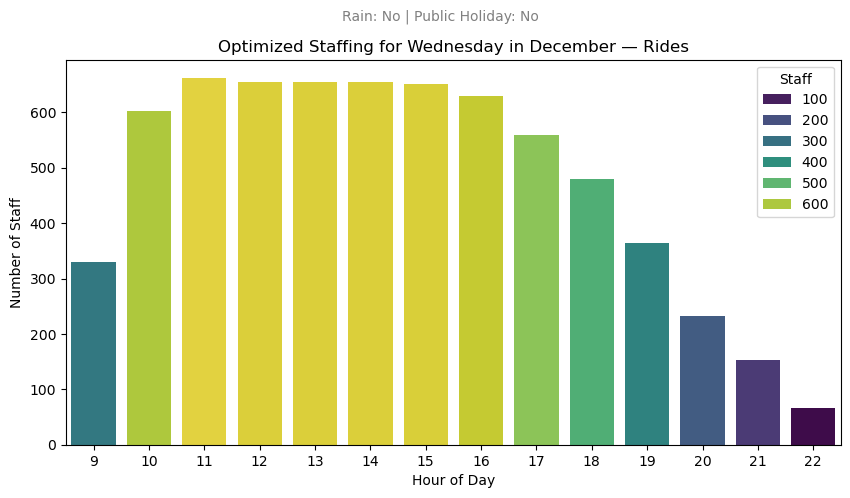

In [84]:
selected_month = "December"
selected_day = "Wednesday"
rain_status = False
public_holiday_status = False

staff_schedule = optimize_staffing(selected_month, selected_day, rain_status, public_holiday_status)
print(staff_schedule)
plot_staffing(staff_schedule, selected_month, selected_day, rain_status, public_holiday_status)